### Real Estate Multi-label room classification

The task here is to perform rich label classification of room images. This is often useful to identfiy multiple features from a single room image, for example image may have both dining_room and kitchen alongwith other rich labels such as kitchen_island, appliances, chandelier, etc. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
import matplotlib.pyplot as plt
import seaborn as sns
import json

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/fellowship.ai/realestate/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
data_path = Path(root_dir+'data/redfin/')
data_path

PosixPath('/content/gdrive/My Drive/Colab Notebooks/fellowship.ai/realestate/data/redfin')

#### Load Dataset

 We manually labelled ~2000 images with multiple-labels per image. We have 36 unique labels

In [0]:
path = Path(root_dir)
def CustomParser(data):
    return json.loads(data)


df = pd.read_csv(path/'data/train.csv', converters={'label':CustomParser})

In [4]:
df.head()

,image_path,label
0,5000_3.jpg,"{'multi-label': ['kitchen', 'ceramic_flooring'..."
1,5000_4.jpg,"{'multi-label': ['living_room', 'ceramic_floor..."
2,5000_5.jpg,"{'multi-label': ['living_room', 'ceramic_floor..."
3,5000_6.jpg,"{'multi-label': ['bedroom', 'window_drapes', '..."
4,5000_7.jpg,"{'multi-label': ['window_drapes', 'window_blin..."


In [0]:
labels = []
img_list = []
for row in df.iterrows():
    x = row[1].label['multi-label']
    labels.append(' '.join(x))
    img_list.append(row[1].image_path)

In [0]:
new_df = pd.DataFrame()
new_df['image_path'] = img_list
new_df['label'] = labels

In [7]:
new_df.shape

(2033, 2)

In [0]:
df = new_df.sort_values('image_path').reset_index().drop(['index'],axis=1)

In [18]:
df['valid'] = False
df.tail(198)['valid']=True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
#np.random.seed(42)
data = (ImageList.from_df(df,data_path).split_from_df(col='valid')
       .label_from_df(label_delim=' ').transform(get_transforms(do_flip=False, xtra_tfms=rand_resize_crop(224)),size=224)
        .databunch(bs=32).normalize(imagenet_stats))

In [22]:
data.sanity_check

<bound method DataBunch.sanity_check of ImageDataBunch;

Train: LabelList (1835 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
exterior;yard;parking_garage,exterior;yard;parking_garage,kitchen;kitchen_island;ceramic_flooring;appliances,kitchen;kitchen_island;appliances;ceramic_flooring,exterior
Path: /content/gdrive/My Drive/Colab Notebooks/fellowship.ai/realestate/data/redfin;

Valid: LabelList (198 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
exterior;yard,dining_room;hardwood_flooring,interior;ceiling_fan;carpet,interior;sliding_windows;carpet;ceiling_fan,bathroom;jacuzzi_bathtub
Path: /content/gdrive/My Drive/Colab Notebooks/fellowship.ai/realestate/data/redfin;

Test: None>

In [0]:
data.train_dl = data.train_dl.new(shuffle=True)

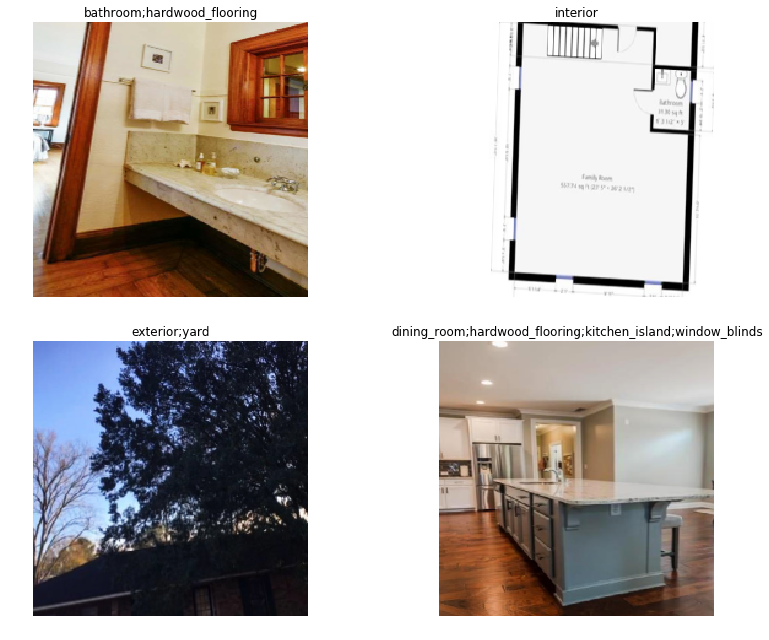

In [24]:
data.show_batch(rows=2, figsize=(12,9))

### Train Model

In [25]:
acc_02 = partial(accuracy_thresh, thresh=0.7)
learn = cnn_learner(data, models.densenet121, metrics=[acc_02],model_dir = Path('models').absolute())

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 20761366.63it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


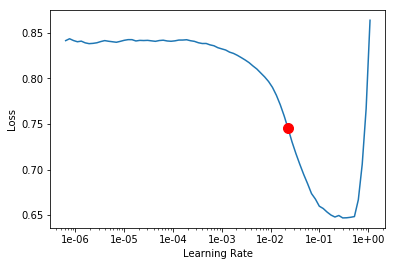

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.495632,0.136010,0.946549,06:20
1,0.229779,0.107171,0.961981,04:56
2,0.154325,0.095197,0.963384,16:16
3,0.121150,0.084952,0.966190,02:58
4,0.103340,0.083767,0.965629,02:04


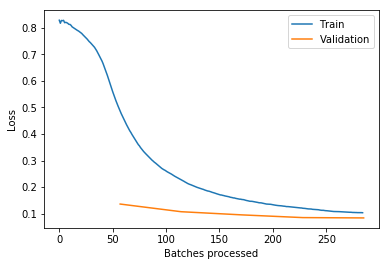

In [27]:
learn.fit_one_cycle(5,max_lr=slice(1e-02))
learn.recorder.plot_losses()

In [0]:
path = Path(root_dir)
learn.save(path/'models/redfin-multi-label-stage-1')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


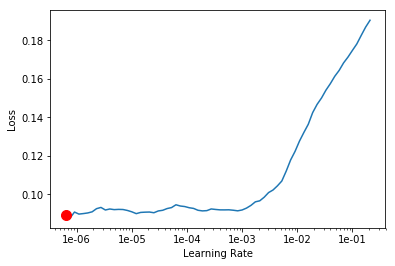

In [33]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
min_grad_lr = learn.recorder.min_grad_lr

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.088601,0.083312,0.965769,01:17
1,0.092277,0.082785,0.966049,01:17
2,0.091339,0.083120,0.965909,01:16


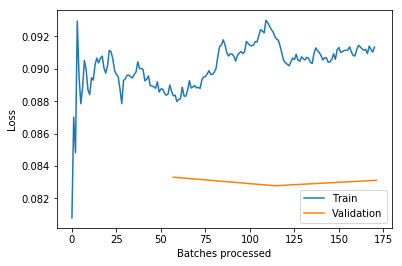

In [34]:
learn.fit_one_cycle(3,max_lr=slice(1e-06,1e-05))
learn.recorder.plot_losses()

In [0]:
path = Path(root_dir)
learn.save(path/'models/redfin-multi-label-stage-2')

#### Results

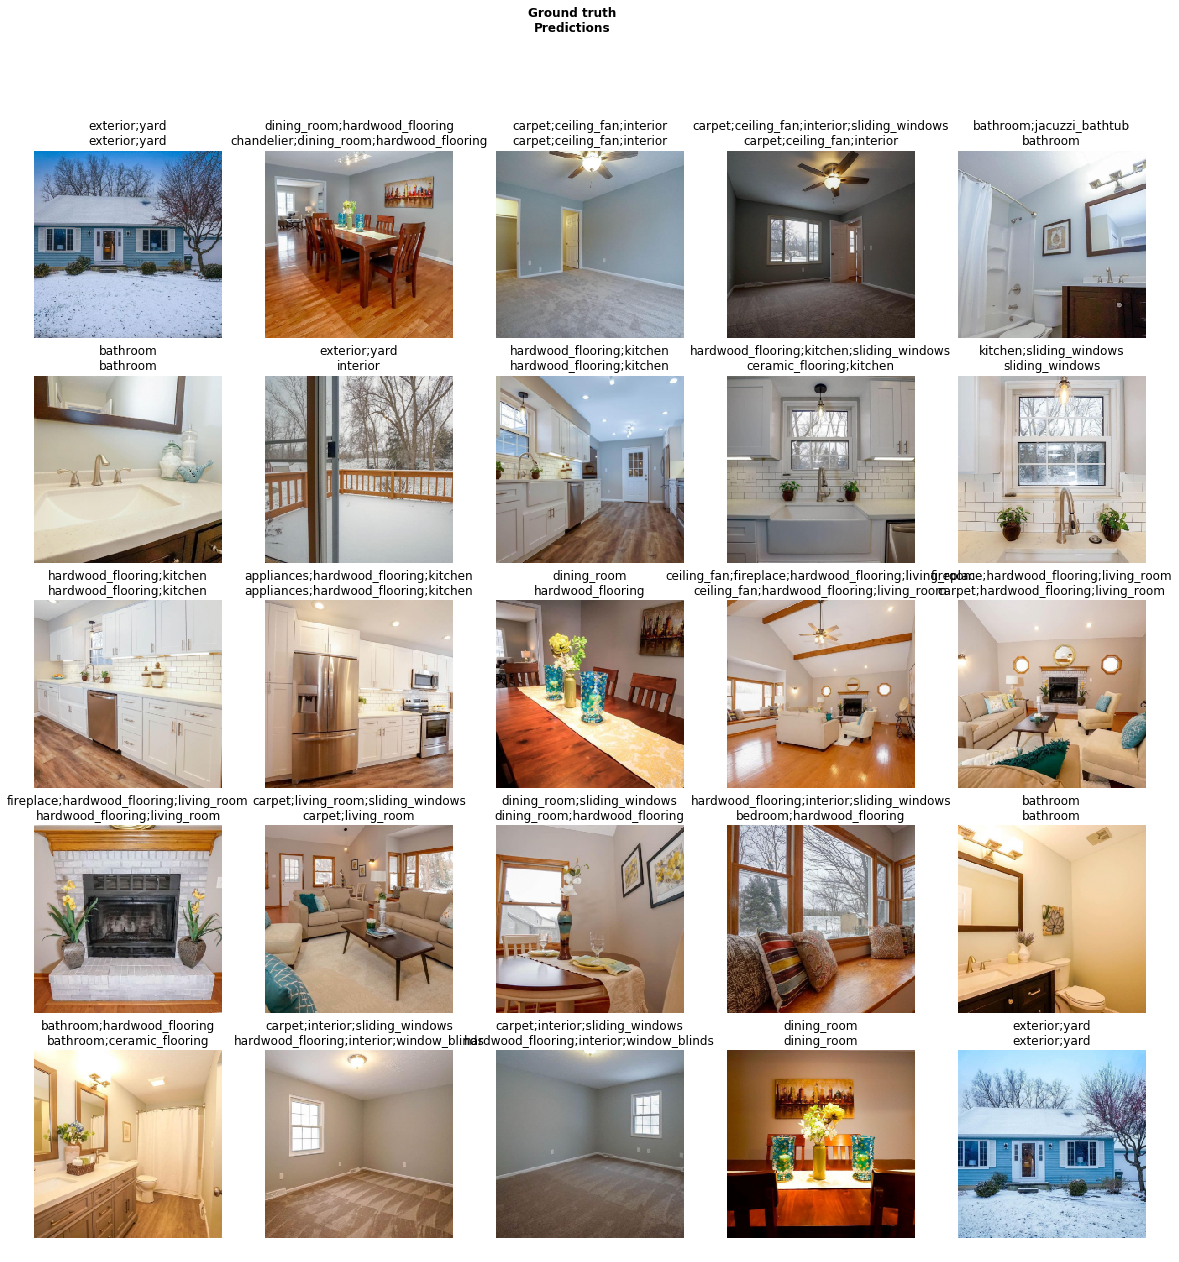

In [36]:
learn.show_results()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

19 misclassified samples over 198 samples in the validation set.


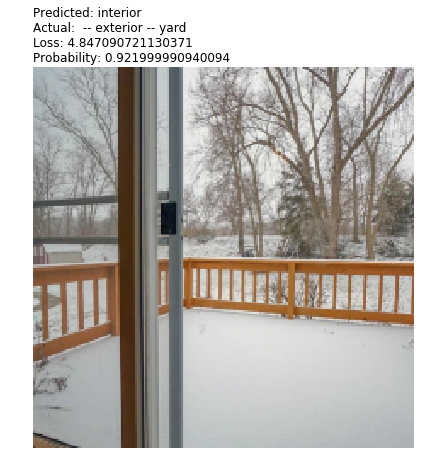

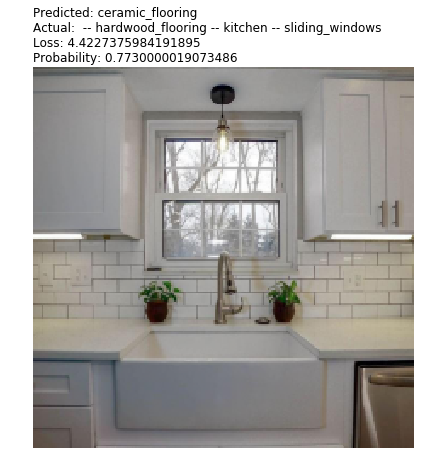

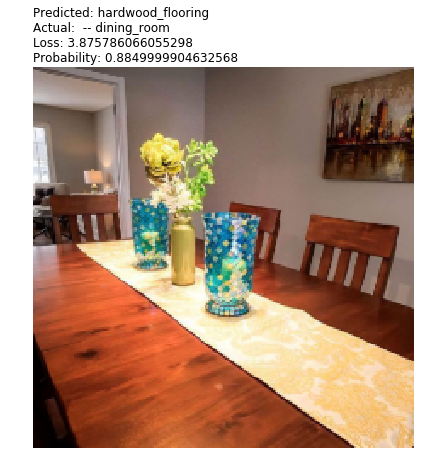

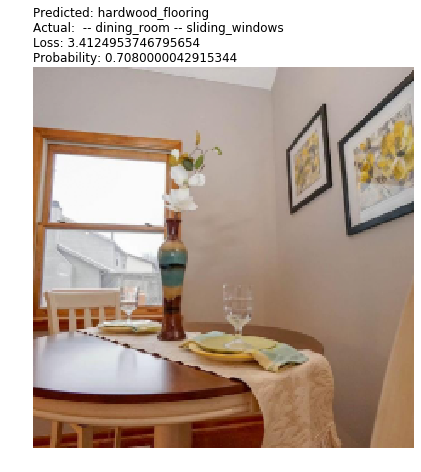

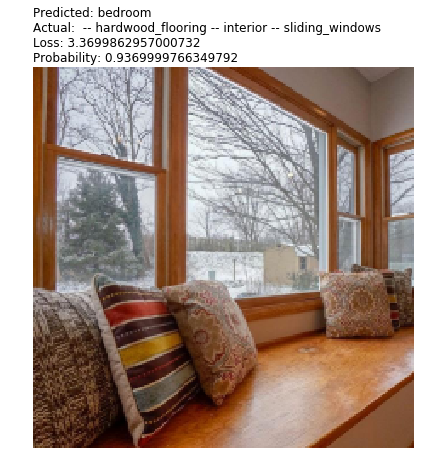

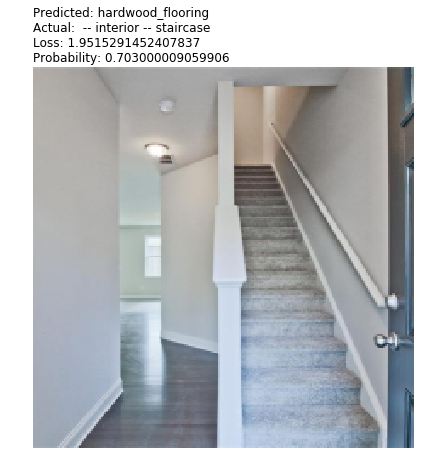

In [38]:
interp.plot_multi_top_losses(6, figsize=(7,7))

#### Conclusion
- From model plot, it seems to perform really well with densenet121. We could get suprisingly good accuracy- 96%. This is supported by learner output shown above. The model is able to predict most of rich labels correctly. we use partial accuracy metric for multi-label evaluation. The threshold is 70% which checks for 70% of the label match from real labels for each particular instance